In [2]:
"""
Created on Tue May  4 00:11:06 2021

@author: YUSUF BARAN TANRIVERDİ


"""
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# accuracy_score average_precision_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, balanced_accuracy_score, precision_score
from sklearn.metrics import roc_curve

data = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')


In [3]:
# Turn categorical values into label encoding
# ref: https://pbpython.com/categorical-encoding.html

def label_encoding(data, feature_name):
    # encodes with an alphabetical order  of original titles
    data[feature_name] = data[feature_name].astype('category')
    data[feature_name] = data[feature_name].cat.codes
    return


label_encoding(data, 'gender')
label_encoding(data, 'ever_married')
label_encoding(data, 'work_type')
label_encoding(data, 'Residence_type')
label_encoding(data, 'smoking_status')

In [4]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,2,1,83.75,NaN,2,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1,0


SPECIAL CASES
1) NaN values
A very common way to replace missing values is using a median.
Replace using median 

ref: https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b

2) UNKNOWN values of smoking status
 What to do? 
 They shouldn't play as a factor category- 
 i.e they should be neutral on the subject of smoking is whether harmful or not!
 For now, let's pass them as another category.
 

In [5]:
median = data['bmi'].median()
data['bmi'].fillna(median, inplace=True)

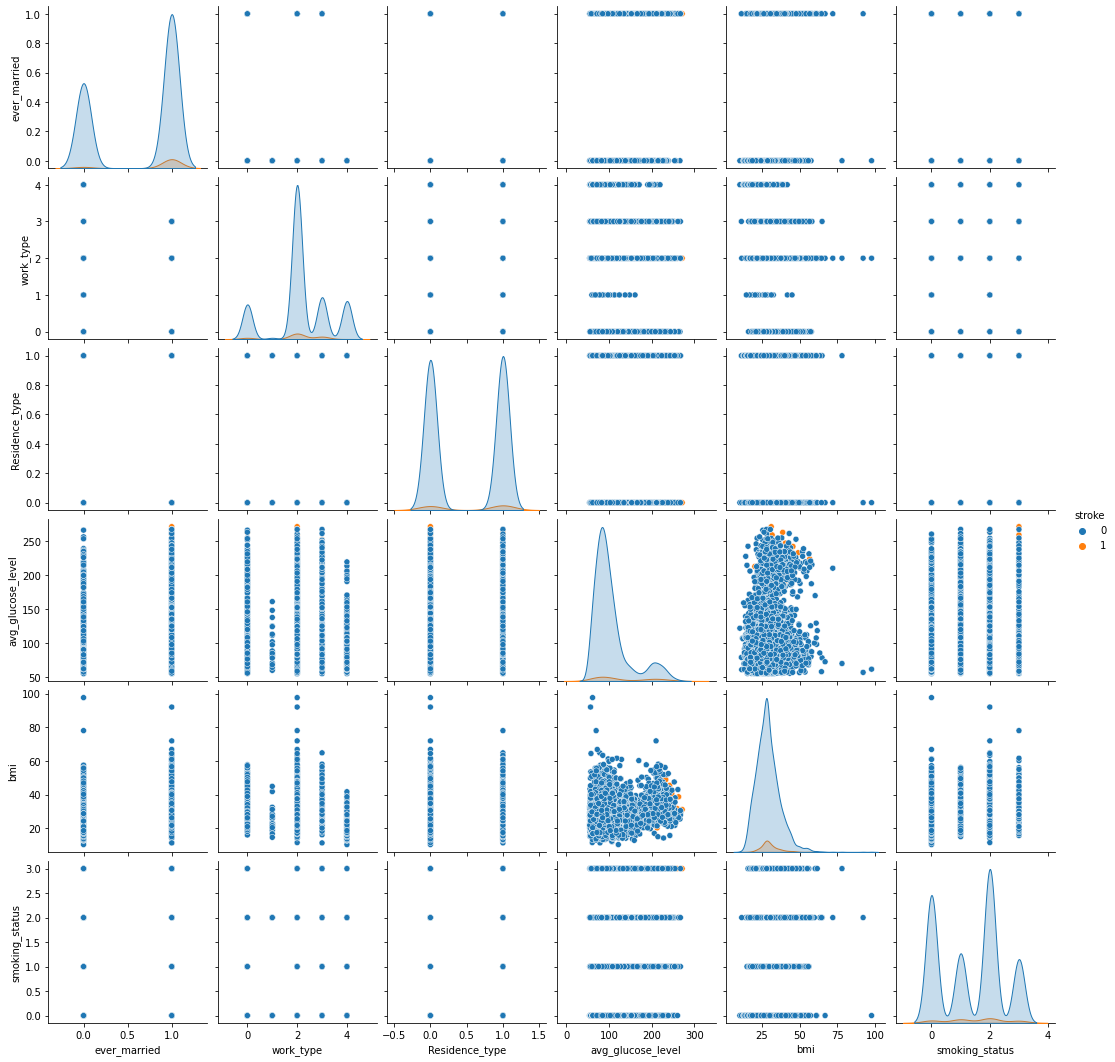

In [6]:
sns.pairplot(data.iloc[:, 5:], hue='stroke') 
plt.show()

It is seen that data is imbalanced heavily. Let's experiment with that before handling.

**Create Datasets**

In [7]:
# create datasets    
xy = data.iloc[:, 1:].to_numpy()
np.random.shuffle(xy)


x = xy[:, :-1]
y = xy[:, -1]

**Some Useful Functions**

In [8]:
def convert_one_hot_vectors(y):
    target_list = []
    one_hot = np.eye(2)
    for target in y:
        if target == 0:
            target_list.append(one_hot[0])
        if target == 1:
            target_list.append(one_hot[1])
    y = np.asarray(target_list)
    
    #x, y = shuffle_data(x, y)
    return y

def get_accuracy(y_preds, y_labels):
    matches = 0
    for boolean in y_preds == y_labels:
        if boolean == True: matches = matches +1
    return matches/ len(y_labels)* 100

#ref:https://scikit-learn.org/stable/modules/model_evaluation.html
def confusion_matrix_scorer(y_preds, y_labels):
    cm = confusion_matrix(y_labels, y_preds)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

#ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_roc_auc_curve(y_preds, y_labels, model_name):
    ns_auc = roc_auc_score(y_labels, np.zeros(y_labels.shape))
    lr_auc = roc_auc_score(y_labels, y_preds)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(f'{model_name}: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, np.zeros(y.shape))
    lr_fpr, lr_tpr, _ = roc_curve(y, preds)
    # plot the roc curve for the model
    ns_curve, = plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'{model_name}')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    ns_curve.remove()

def print_metrics(y_preds, y_labels, model_name):
    print("\n MODEL: ", model_name )
    
    print("Accuracy:", get_accuracy(y_preds, y_labels))
    print("Null rate of test:", get_accuracy(y_preds, np.zeros(y.shape)))
    print("\n CONFUSION MATRIX")
    print(confusion_matrix_scorer(y_preds, y_labels))

    # recall is tp/ (tp+fn)
    print("Recall: ", recall_score(y_preds, y_labels))
    
    # precision is tp/(tp+fp)
    print("Precision:", precision_score(y_preds, y_labels))
    
    # (recall+ specificity)/2
    print("Balanced Accuracy:", balanced_accuracy_score(y_labels, y_preds)* 100)


def fit_LinearRegression():
    regressor = LinearRegression()
    tmp_y = convert_one_hot_vectors(y)
    regressor.fit(x,tmp_y)
        
    probs = regressor.predict(x)
    return  probs, regressor

EXP1 LINEAR REGRESSION

In [9]:
probs, _  = fit_LinearRegression()
preds = np.argmax(probs, axis= 1)
print_metrics(preds, y, 'Linear Regression (imbalanced data)')
# balanced accuracy in this case would be 0.5


print("PREVELANCE -> pr(stroke|sample) = ",len(data[data['stroke'] == 1])/len(data))
# see the scatter plot also.





 MODEL:  Linear Regression (imbalanced data)
Accuracy: 95.12720156555773
Null rate of test: 100.0

 CONFUSION MATRIX
{'tn': 4861, 'fp': 0, 'fn': 249, 'tp': 0}
Recall:  0.0
Precision: 0.0
Balanced Accuracy: 50.0
PREVELANCE -> pr(stroke|sample) =  0.0487279843444227


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It always give 'negative'. Imbalanced target problem?   Yes, solutions might be:
    
SMOTE

MODEL CHANGING

DIFFERENT METRIC EVALUATION 

(ref: https://towardsdatascience.com/regression-for-imbalanced-data-with-application-edf93517247c)

EXP2 SMOTE - REGRESSION

In [10]:
from imblearn.over_sampling import SMOTENC

#CALL RAW DATA
x = xy[:, :-1]
y = xy[:, -1]

#SMOTE the data with SMOTENC algorithm
cat_col_index = [0, 4, 5, 6, 9]
oversample = SMOTENC(categorical_features=cat_col_index, k_neighbors=2)
x, y = oversample.fit_resample(x, y)

df = pd.DataFrame(x, columns= ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])

df['stroke'] = y
# print(df)
#sns.pairplot(df.iloc[:, 5:], hue='stroke') 
#plt.show()
#sns.pairplot(df.iloc[:, 5:], hue='stroke') 
#plt.show()
print(" \n AFTER SMOTENC...")

probs, linearModelv2 = fit_LinearRegression()
preds = np.argmax(probs, axis= 1)

print_metrics(preds, y, 'Linear Regression after SMOTE')

print(" NEW PREVELANCE ->pr(stroke|sample) = ", len(df[df['stroke'] == 1])/len(df))

 
 AFTER SMOTENC...

 MODEL:  Linear Regression after SMOTE
Accuracy: 77.06233285332236
Null rate of test: 45.577041760954536

 CONFUSION MATRIX
{'tn': 3531, 'fp': 1330, 'fn': 900, 'tp': 3961}
Recall:  0.7486297486297486
Precision: 0.8148529109236783
Balanced Accuracy: 77.06233285332236
 NEW PREVELANCE ->pr(stroke|sample) =  0.5


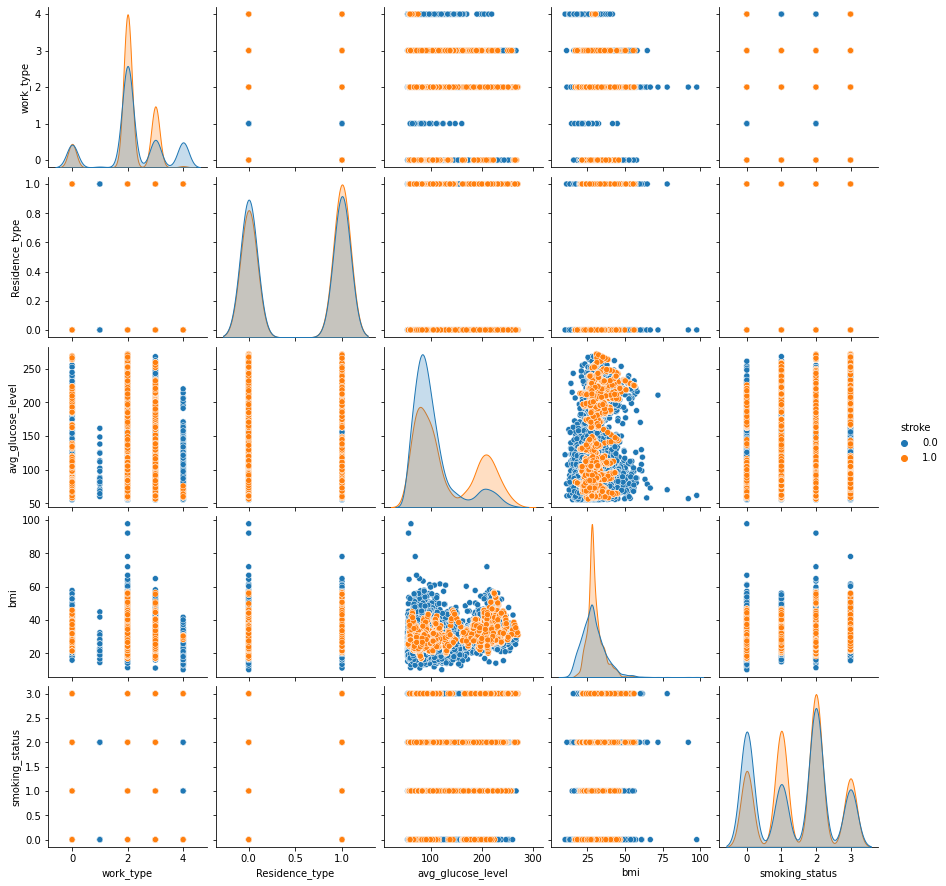

In [11]:
sns.pairplot(df.iloc[:, 5:], hue='stroke') 
plt.show()

EXP3 DEEP LEARNING METHODS

REFERENCES:
 https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

 https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323

 https://towardsdatascience.com/multi-layer-perceptron-using-tensorflow-9f3e218a4809


In [12]:
# import libs and define some useful functions
from keras.layers import *
import tensorflow as tf
import keras

def get_evaluation_accuracy(history):
    return 100 * history['accuracy']


def plot_metrics(model_name, history, metric_name):
    plt.figure()
    e = range(1, len(history.history[metric_name]) + 1)
    plt.plot(e, history.history[metric_name], 'bo', label=metric_name)
    plt.plot(e, history.history[f'val_{metric_name}'], 'b', label=f'val_{metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric_name}')
    plt.legend(loc='lower right')
    plt.title(f'Comparing training and validation loss of {model_name}')
    plt.savefig(f'./{model_name}.png')

def metrics_table_for_evaluation(model_name, history):
    tp = history['true_pos']
    fp = history['false_pos']
    tn = history['true_neg']
    fn = history['false_neg']
    
    cm = pd.DataFrame(index=('predicted YES', 'predicted NO'), columns=('actual YES', 'actual NO'))
    cm.iloc[0,0] = np.mean(tp)
    cm.iloc[0,1] = np.mean(fn)
    cm.iloc[1,0] = np.mean(fp)
    cm.iloc[1,1] = np.mean(tn)
    
    mcs = pd.DataFrame(index=[model_name], columns=('recall (TPR)', 'specificty', 'sensitivity', 'precision', 'false positive rate', 'accuracy'))
    
    mcs.iloc[0,0] = np.mean(tp)/ (np.mean(tp)+ np.mean(fp))
    mcs.iloc[0,1] = np.mean(tn)/ (np.mean(tn)+ np.mean(fp)) 
    mcs.iloc[0,2] = np.mean(tp)/ (np.mean(tp)+ np.mean(fn)) 
    mcs.iloc[0,3] = np.mean(tp)/ (np.mean(tp)+ np.mean(fp)) 
    mcs.iloc[0,4] = np.mean(fp)/ (np.mean(tn)+ np.mean(fp)) 
    mcs.iloc[0,5] = np.mean(history['accuracy']) 
    
    print(cm)
    print(mcs)

In [13]:
#HYPERPARAMATERS

LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
EPOCHS= 100
BATCH_SIZE = 10
LOSS_FN = 'binary_crossentropy'

In [14]:
# create train_dataset
# test split %90

boundary = int(len(x) *0.1)
x_train = x[boundary:]
y_train = y[boundary:]
    
# create test_dataset
x_test = x[:boundary]
y_test = y[:boundary]

DEFINE MODEL with a dropout layer.

In [15]:
def dropout_dnn(number_of_classes=2, lr=LEARNING_RATE, dr=DROPOUT_RATE):
    model = keras.Sequential([
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(dr),
        Dense(64, activation='relu'),
        Dropout(dr),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss=LOSS_FN,
                  metrics=['accuracy', 
                           tf.keras.metrics.TrueNegatives(name='true_neg'),
                           tf.keras.metrics.FalsePositives(name='false_pos'),
                           tf.keras.metrics.FalseNegatives(name='false_neg'),
                           tf.keras.metrics.TruePositives(name='true_pos'),
                           ],
                  optimizer=tf.keras.optimizers.Adam(lr))
    return model



To stop training when no change happens:

In [16]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

**Tranining**

In [17]:
densenet = dropout_dnn()
dropout_history = densenet.fit(x_train, y_train, validation_split=0.2, 
                               batch_size=BATCH_SIZE, verbose=1, epochs=EPOCHS
                               )

#save model
tf.keras.models.save_model(
    densenet,
    './models/densenet.h5'
)


pd.DataFrame.from_dict(dropout_history.history).to_csv('./dropout_histor.csv', index=False)



Epoch 1/100
700/700 [==============================] - 4s 4ms/step - loss: 1.1577 - accuracy: 0.5685 - true_neg: 1167.3509 - false_pos: 809.7504 - false_neg: 627.7461 - true_pos: 905.1384 - val_loss: 0.5798 - val_accuracy: 0.8194 - val_true_neg: 0.0000e+00 - val_false_pos: 0.0000e+00 - val_false_neg: 316.0000 - val_true_pos: 1434.0000
Epoch 2/100
700/700 [==============================] - 2s 3ms/step - loss: 0.5945 - accuracy: 0.6840 - true_neg: 1499.6904 - false_pos: 469.4679 - false_neg: 659.9044 - true_pos: 880.9230 - val_loss: 0.7498 - val_accuracy: 0.4223 - val_true_neg: 0.0000e+00 - val_false_pos: 0.0000e+00 - val_false_neg: 1011.0000 - val_true_pos: 739.0000
Epoch 3/100
700/700 [==============================] - 2s 3ms/step - loss: 0.5783 - accuracy: 0.6617 - true_neg: 1533.5920 - false_pos: 439.3524 - false_neg: 735.0499 - true_pos: 801.9914 - val_loss: 0.5586 - val_accuracy: 0.8400 - val_true_neg: 0.0000e+00 - val_false_pos: 0.0000e+00 - val_false_neg: 280.0000 - val_true_pos:

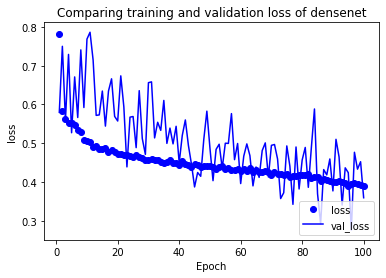

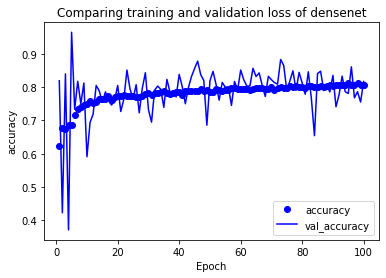

In [18]:
plot_metrics(history=dropout_history, metric_name='loss', model_name='densenet')
plot_metrics(history=dropout_history, metric_name='accuracy', model_name='densenet')

In [19]:
eval_history = densenet.evaluate(x_test, y_test, return_dict=True)

metrics_table_for_evaluation('MLP test', eval_history)

31/31 [==============================] - 1s 2ms/step - loss: 0.3986 - accuracy: 0.8169 - true_neg: 761.0000 - false_pos: 164.0000 - false_neg: 14.0000 - true_pos: 33.0000
              actual YES actual NO
predicted YES       33.0      14.0
predicted NO       164.0     761.0
         recall (TPR) specificty sensitivity precision false positive rate  \
MLP test     0.167513   0.822703    0.702128  0.167513            0.177297   

          accuracy  
MLP test  0.816872  


In [20]:
metrics_table_for_evaluation('MLP train', dropout_history.history)




              actual YES actual NO
predicted YES    2377.16    686.84
predicted NO      845.04   3090.96
          recall (TPR) specificty sensitivity precision false positive rate  \
MLP train     0.737744   0.785305    0.775836  0.737744            0.214695   

          accuracy  
MLP train  0.78116  


In [21]:
print("NULL RATE")
densenet.evaluate(x_test, np.zeros(y_test.shape))

print("FULL RATE")
indices = [i for i in range(len(y)) if y[i]==1]
densenet.evaluate(x_test, np.ones(y_test.shape))

NULL RATE
31/31 [==============================] - 0s 2ms/step - loss: 0.4284 - accuracy: 0.7973 - true_neg: 775.0000 - false_pos: 197.0000 - false_neg: 0.0000e+00 - true_pos: 0.0000e+00
FULL RATE
31/31 [==============================] - 0s 2ms/step - loss: 11.4306 - accuracy: 0.2027 - true_neg: 0.0000e+00 - false_pos: 0.0000e+00 - false_neg: 775.0000 - true_pos: 197.0000


[11.430578231811523, 0.20267489552497864, 0.0, 0.0, 775.0, 197.0]

EXP4 XGBOOST

In [22]:
from collections import Counter

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [34]:
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)


In [42]:
model.fit(x, y)

[15:43:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
evals_result = model.score(x_test, y_test)

evals_result

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.9917695473251029